In [1]:
import seaborn as sns
import pylab as pl
#from plotting import load_experiments
import numpy as np
import pandas as pd
import scipy.io as scio
from models.covFunctions import *

from venture import shortcuts
import sys
sys.path.append('../SPs/')
import venture.lite.types as t
from venture.lite.function import VentureFunction
import gp_with_der

from models.tools import array
figlength = 30
figheigth = 15
import random

figlength = 10
figheigth = 10

In [2]:
sns.set(font_scale=2)

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
no = "s"

In [5]:
n = 200

In [6]:
def f(x):
    return 0.3 + 0.4*x + 0.5*np.sin(2.7*x) + (1.1/(1+x**2))

In [7]:
x2plot = np.linspace(-3,3,1000)
f2plot = f(x2plot)

In [8]:
x = np.random.normal(0,1,n)
y=np.zeros(x.shape)

In [9]:
for i in range(n):
    if random.random()>0.10:
        y[i] = f(x[i]) + np.random.normal(0,0.1,1)
    else:
        y[i] = f(x[i]) + np.random.normal(0,1,1)
        


In [10]:
def array(xs):
  return t.VentureArrayUnboxed(np.array(xs),  t.NumberType())

def makeObservations(x,y):
    xString = genSamples(x)
    ripl.observe(xString, array(y))

def genSamples(x):
    sampleString='(gp (array '
    for i in range(len(x)):
        sampleString+= str(x[i]) + ' '
    sampleString+='))'
    #print(sampleString)
    return sampleString




In [11]:
ripl = shortcuts.make_lite_church_prime_ripl()
ripl.bind_foreign_sp("make_gp_part_der",gp_with_der.makeGPSP)
ripl.assume('make_const_func', VentureFunction(makeConstFunc, [t.NumberType()], constantType))
ripl.assume('zero', "(apply_function make_const_func 0)")

<function models.covFunctions.<lambda>>

In [12]:
#ripl.infer('(resample 100)')

In [13]:
#ripl.assume("func_times", makeLiftedMult(lambda x1, x2: np.multiply(x1,x2)))
ripl.assume("func_plus", makeLiftedAdd(lambda x1, x2: x1 + x2))

<function models.covFunctions.wrapped>

In [14]:
ripl.assume('make_se',VentureFunction(makeSquaredExponential,[t.NumberType(), t.NumberType()], t.AnyType("VentureFunction")))
ripl.assume('make_noise',VentureFunction(makeNoise,[t.NumberType()], t.AnyType("VentureFunction")))

ripl.assume('alpha_sf','(tag (quote hyperhyper) 0 (gamma 7 1))')
ripl.assume('beta_sf','(tag (quote hyperhyper) 2 (gamma 1 0.5))')
ripl.assume('alpha_l','(tag (quote hyperhyper) 1 (gamma 7 1))')
ripl.assume('beta_l','(tag (quote hyperhyper) 3 (gamma 1 0.5))')


ripl.assume('sf','(tag (quote hyper) 0  (gamma alpha_sf beta_sf ))')
ripl.assume('l','(tag (quote hyper) 1  (gamma alpha_l beta_l ))')

ripl.assume('sigma','(tag (quote hyper) 2 (uniform_continuous 0 2 ))')

ripl.assume('se', "(apply_function make_se sf l )")
ripl.assume('wn','(apply_function make_noise sigma  )')


<function models.covFunctions.f>

In [15]:
ds = ripl.infer('(collect sf l sigma)')
df = ds.asPandas()
df['Hyper-Parameter Learning']= pd.Series(['before' for _ in range(len(df.index))], index=df.index)

In [16]:
df_before =df

In [17]:
ripl.assume('t_dist','(lambda (i) (student_t 4))')



ripl.assume('gp',"""(tag (quote model) 0
                        (make_gp_part_der zero (apply_function func_plus se wn  ) 
                                )
                         
                             )""")



In [18]:
df_before

,iter,prt. id,time (s),log score,prt. log wgt.,prt. prob.,sf,l,sigma,Hyper-Parameter Learning
0,1,0,0.719266,-15.309733,0,1,2.07186,30.196204,1.820389,before


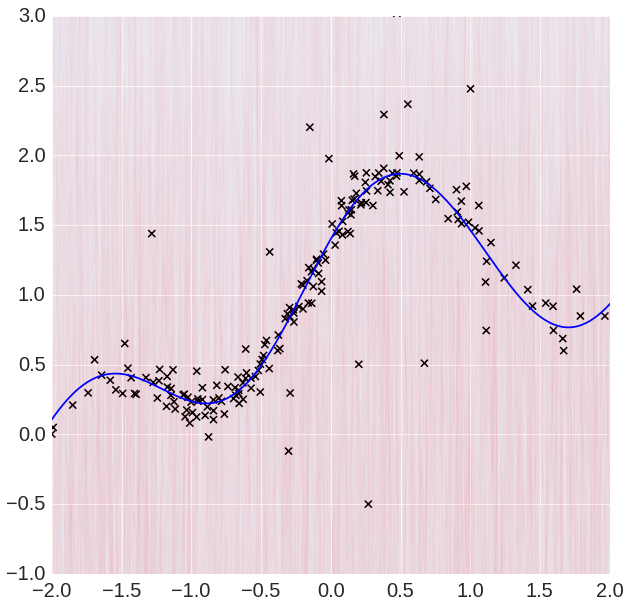

In [19]:

fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
#xpost= np.random.uniform(-3,3,200)
for i in range(100):
    xpost= np.random.uniform(-3,3,200)
    sampleString=genSamples(xpost)
    ypost = ripl.sample(sampleString)
    yp = [y_temp for (x_temp,y_temp) in sorted(zip(xpost,ypost))]
    pl.plot(sorted(xpost),yp,c="red",alpha=0.008,linewidth=2)

plt.axis((-2,2,-1,3))
pl.plot(x2plot,f2plot,color='blue')
pl.scatter(x,y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')   
    
fig.savefig('/home/ulli/Paper_VentureGP/figs/neal_se_1'+no+'.svg', dpi=fig.dpi)
fig.savefig('/home/ulli/Paper_VentureGP/figs/neal_se_1'+no+'.png', dpi=fig.dpi)

In [20]:
makeObservations(x,y)


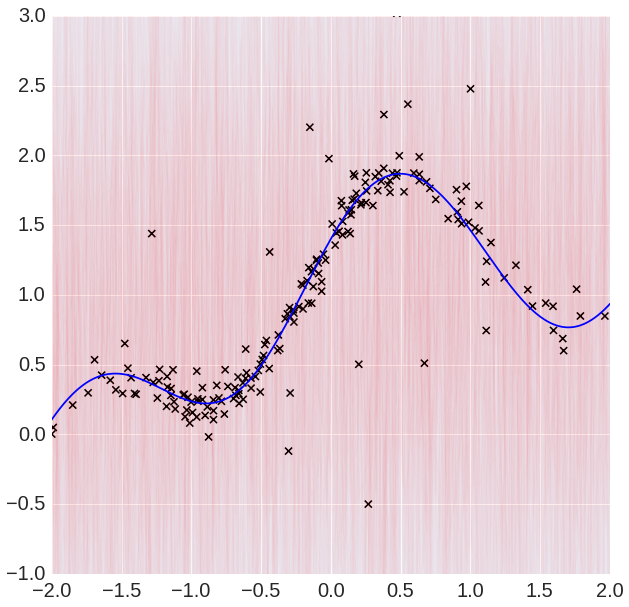

In [21]:

fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
#xpost= np.random.uniform(-3,3,200)
for i in range(100):
    xpost= np.random.uniform(-3,3,200)
    sampleString=genSamples(xpost)
    ypost = ripl.sample(sampleString)
    yp = [y_temp for (x_temp,y_temp) in sorted(zip(xpost,ypost))]
    pl.plot(sorted(xpost),yp,c="red",alpha=0.008,linewidth=2)

plt.axis((-2,2,-1,3))
pl.plot(x2plot,f2plot,color='blue')
pl.scatter(x,y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')   
    
fig.savefig('/home/ulli/Paper_VentureGP/figs/neal_se_2'+no+'.svg', dpi=fig.dpi)
fig.savefig('/home/ulli/Paper_VentureGP/figs/neal_se_2'+no+'.png', dpi=fig.dpi)

In [22]:
rd = ripl.infer("(collect sf l sigma alpha_l beta_l alpha_sf beta_sf)")
df_parameter_before = rd.asPandas()
df_parameter_before.to_pickle("syndata/before_parammeter")

In [23]:
print(ripl.infer("global_posterior"))

[-568.38644385254656]


In [24]:

ripl.infer("(repeat 100 (do (mh (quote hyperhyper) one 2) (mh (quote hyper) one 1)))")

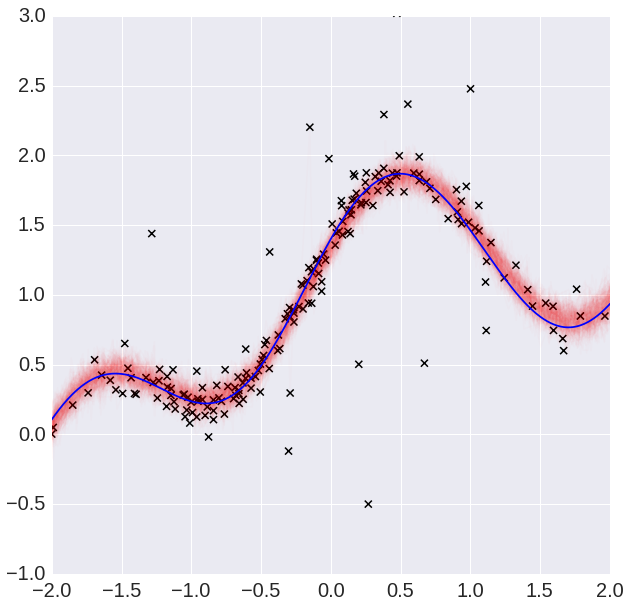

In [25]:

fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
#xpost= np.random.uniform(-3,3,200)
for i in range(200):
    xpost= np.random.uniform(-3,3,200)
    sampleString=genSamples(xpost)
    ypost = ripl.sample(sampleString)
    yp = [y_temp for (x_temp,y_temp) in sorted(zip(xpost,ypost))]
    pl.plot(sorted(xpost),yp,c="red",alpha=0.01,linewidth=2)

plt.axis((-2,2,-1,3))
pl.plot(x2plot,f2plot,color='blue')
pl.scatter(x,y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')

#fig.savefig('/home/ulli/Paper_VentureGP/figs/neal_se_3'+no+'.svg', dpi=fig.dpi)
#fig.savefig('/home/ulli/Paper_VentureGP/figs/neal_se_3'+no+'.png', dpi=fig.dpi)


In [26]:
rd = ripl.infer("(collect sf l sigma alpha_l beta_l alpha_sf beta_sf)")
df_parameter_after = rd.asPandas()
df_parameter_after.to_pickle("syndata/after_parameter")

In [27]:
df_parameter_after['sigma'][0]

0.075833844235849268

In [28]:
df_parameter_after['alpha_sf'][0]

4.6080692383681345